# Laptop Selection Using Analytical Hierarchy Process (AHP)

## Introduction
The goal of this project is to select the best laptop using the Analytical Hierarchy Process (AHP). This method helps in making the best decision by laying out options in a structured way.

## Project Structure
- `code/`: Contains the Python script for the AHP analysis.
- `data/`: Contains the dataset used for the analysis.


In [10]:
import pandas as pd

# Load data
df = pd.read_csv('C:/Users/Sandeep Mondkar/Downloads/Laptop selection using AHP/laptop dataset.csv')

# Print column names for debugging
print("Column names in the DataFrame:", df.columns)

# Fixed weights for ranks
weights = {1: 0.30, 2: 0.25, 3: 0.20, 4: 0.15, 5: 0.10, 6: 0.05, 7: 0.03, 8: 0.02}

# Set pandas display options to show all columns
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)  # Set to None to prevent truncation based on width
pd.set_option('display.max_colwidth', None)  # Set to None to prevent truncation of individual cell width


Column names in the DataFrame: Index(['Laptop Model', 'Processor', 'Processor Score', 'Graphics Card',
       'Graphics Score', 'Battery Life', 'Battery Life Score', 'RAM',
       'Storage', 'Walmart Price', 'Amazon Price', 'Best Buy Price',
       'Official Website Price', 'Average Price', 'Cost Score',
       'Student Discount', 'Student Discount Score', 'Performance Rating',
       'Performance Rating Score', 'Reliability Rating', 'Reliability Score',
       'Customer Rating', 'Customer Rating Score',
       'Most Possible Defected Part', 'Most Possible Defected Part Score'],
      dtype='object')


In [11]:
# Function to map RAM and Storage to numeric values
def map_ram_storage(df):
    ram_mapping = {"8GB": 8, "16GB": 16, "32GB": 32, "64GB": 64}
    storage_mapping = {"256GB SSD": 256, "512GB SSD": 512, "1TB SSD": 1024, "2TB SSD": 2048}
    df['RAM'] = df['RAM'].map(ram_mapping)
    df['Storage'] = df['Storage'].map(storage_mapping)
    return df

df = map_ram_storage(df)

In [12]:
import tkinter as tk
from tkinter import ttk
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize Tkinter
root = tk.Tk()
root.title("Laptop Ranking Dashboard")

# Dropdown options
ram_options = ["8GB", "16GB", "32GB", "64GB"]
storage_options = ["256GB SSD", "512GB SSD", "1TB SSD", "2TB SSD"]

# Labels and dropdowns for RAM and Storage
tk.Label(root, text="Select RAM").grid(row=0, column=0)
ram_combo = ttk.Combobox(root, values=ram_options)
ram_combo.grid(row=0, column=1)

tk.Label(root, text="Select Storage").grid(row=1, column=0)
storage_combo = ttk.Combobox(root, values=storage_options)
storage_combo.grid(row=1, column=1)

# Create dropdowns for criteria selection
criteria = ["Processor Score", "Graphics Score", "Battery Life Score", "Cost Score",
            "Performance Rating Score", "Reliability Score", "Customer Rating Score",
            "Most Possible Defected Part Score"]

dropdowns = []
for i in range(1, 9):
    label = tk.Label(root, text=f"Rank {i}")
    label.grid(row=i + 2, column=0)  # Adjust row position
    combo = ttk.Combobox(root, values=criteria)
    combo.grid(row=i + 2, column=1)  # Adjust row position
    dropdowns.append(combo)

In [13]:
# Function to filter laptops based on RAM and Storage
def filter_laptops():
    ram = ram_combo.get()
    storage = storage_combo.get()
    if ram and storage:
        ram_value = int(ram.replace('GB', ''))
        if 'TB' in storage:
            storage_value = int(storage.replace('TB SSD', '')) * 1024  # Convert TB to GB
        else:
            storage_value = int(storage.replace('GB SSD', ''))
        filtered_df = df[(df['RAM'] == ram_value) & (df['Storage'] == storage_value)]
        print("Filtered laptops based on RAM and Storage:")
        print(filtered_df[['Laptop Model', 'RAM', 'Storage']])  # Debugging: Show filtered laptops
        return filtered_df
    return df

In [14]:
# Function to calculate weighted scores and update visualization
def update_visualization():
    filtered_df = filter_laptops()

    selected_criteria = [combo.get() for combo in dropdowns]
    weighted_scores = pd.Series(0, index=filtered_df.index)

    for i, criterion in enumerate(selected_criteria):
        if criterion:
            print(f"Processing criterion: {criterion}")  # Debugging print
            try:
                weighted_scores += filtered_df[criterion] * weights[i + 1]
            except KeyError as e:
                print(f"KeyError: {e} - Check if the column name exists in the DataFrame")

    filtered_df.loc[:, 'Weighted Score'] = weighted_scores
    top_3 = filtered_df.nlargest(3, 'Weighted Score')

    # Reorder columns: specific columns first, then all other columns
    specific_columns = [
        'Laptop Model', 'Processor', 'Processor Score', 'Graphics Card', 'Graphics Score',
        'Battery Life', 'Battery Life Score', 'RAM', 'Storage', 'Walmart Price', 'Amazon Price',
        'Best Buy Price', 'Official Website Price', 'Average Price', 'Cost Score', 'Student Discount',
        'Student Discount Score', 'Performance Rating', 'Performance Rating Score',
        'Reliability Score', 'Customer Rating', 'Customer Rating Score', 'Most Possible Defected Part'
    ]
    other_columns = [col for col in filtered_df.columns if col not in specific_columns]
    column_order = specific_columns + other_columns

    top_3 = top_3[column_order]

    # Remove 'Reliability Rating' from top_3 DataFrame before displaying
    if 'Reliability Rating' in top_3.columns:
        top_3 = top_3.drop(columns=['Reliability Rating'])

    # Print top 3 DataFrame for debugging
    print("Top 3 laptops DataFrame:")
    print(top_3.to_string(index=False))  # Ensure all columns are printed without truncation

    # Display the pair matrix first
    pair_matrix = filtered_df[selected_criteria].corr()
    plt.figure(figsize=(14, 8))
    sns.heatmap(pair_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
    plt.title("Pairwise Comparison Matrix")
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    # Create a grouped bar chart for score comparison
    metrics = ["Processor Score", "Graphics Score", "Battery Life Score", "Cost Score",
               "Performance Rating Score", "Customer Rating Score", "Reliability Score",
               "Most Possible Defected Part Score"]

    top_3_melted = top_3.melt(id_vars=["Laptop Model"], value_vars=metrics,
                              var_name="Metric", value_name="Score")

    plt.figure(figsize=(14, 8))
    sns.barplot(x="Metric", y="Score", hue="Laptop Model", data=top_3_melted)
    plt.title("Comparison of Scores for Top 3 Laptops")
    plt.xlabel("Metric")
    plt.ylabel("Score")
    plt.legend(title="Laptop Model")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

Filtered laptops based on RAM and Storage:
             Laptop Model   RAM  Storage
4          Razer Blade 17  32.0   2048.0
6             Dell XPS 17  32.0   2048.0
34        MSI Stealth 15M  32.0   2048.0
53         Razer Blade 16  32.0   2048.0
55         Razer Blade 14  32.0   2048.0
57  Dell Alienware m16 R2  32.0   2048.0
61   HP Omen Transcend 16  32.0   2048.0
62        MSI Titan 18 HX  32.0   2048.0
Processing criterion: Reliability Score
Processing criterion: Processor Score
Processing criterion: Graphics Score
Processing criterion: Battery Life Score
Processing criterion: Cost Score
Processing criterion: Performance Rating Score
Processing criterion: Customer Rating Score
Processing criterion: Most Possible Defected Part Score
Top 3 laptops DataFrame:
         Laptop Model               Processor  Processor Score           Graphics Card  Graphics Score Battery Life  Battery Life Score  RAM  Storage Walmart Price Amazon Price Best Buy Price Official Website Price Average Pric

C:\Users\Sandeep Mondkar\AppData\Local\Temp\ipykernel_20276\2767530561.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.loc[:, 'Weighted Score'] = weighted_scores


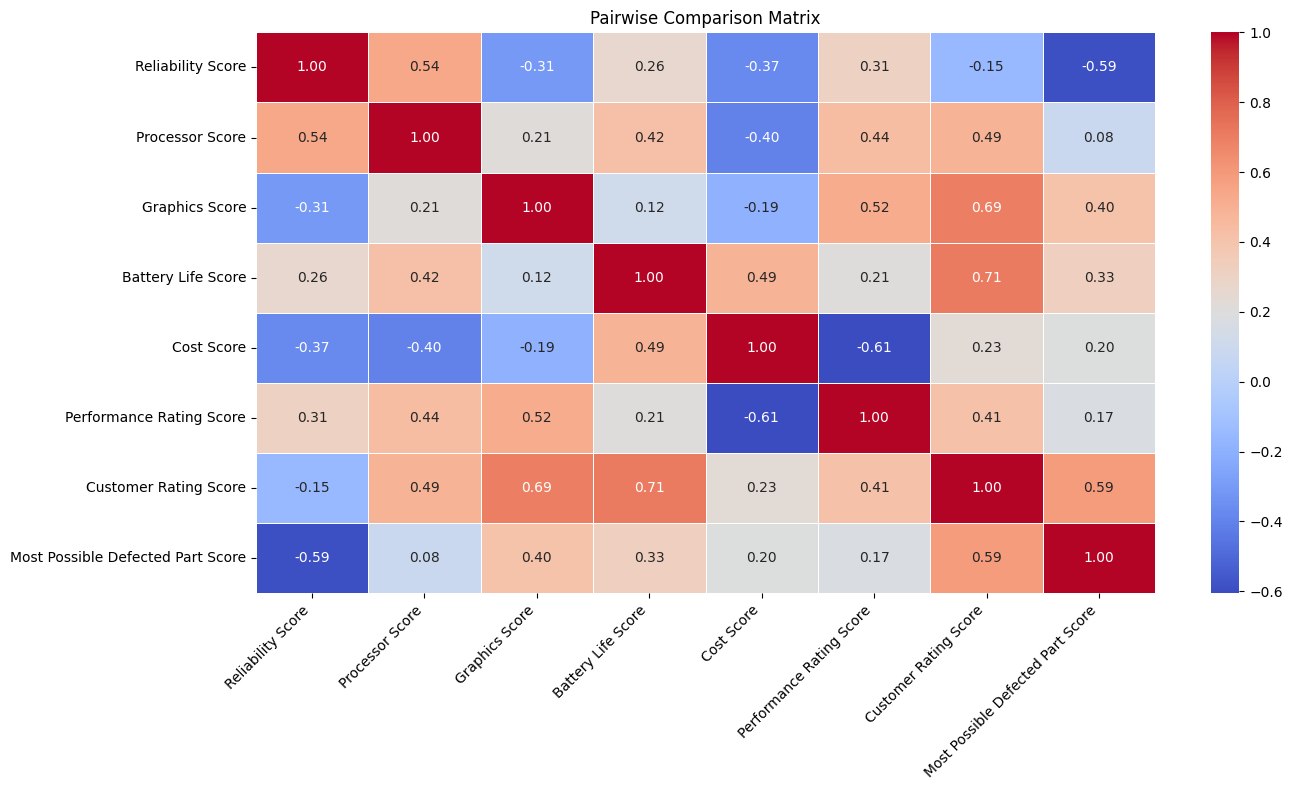

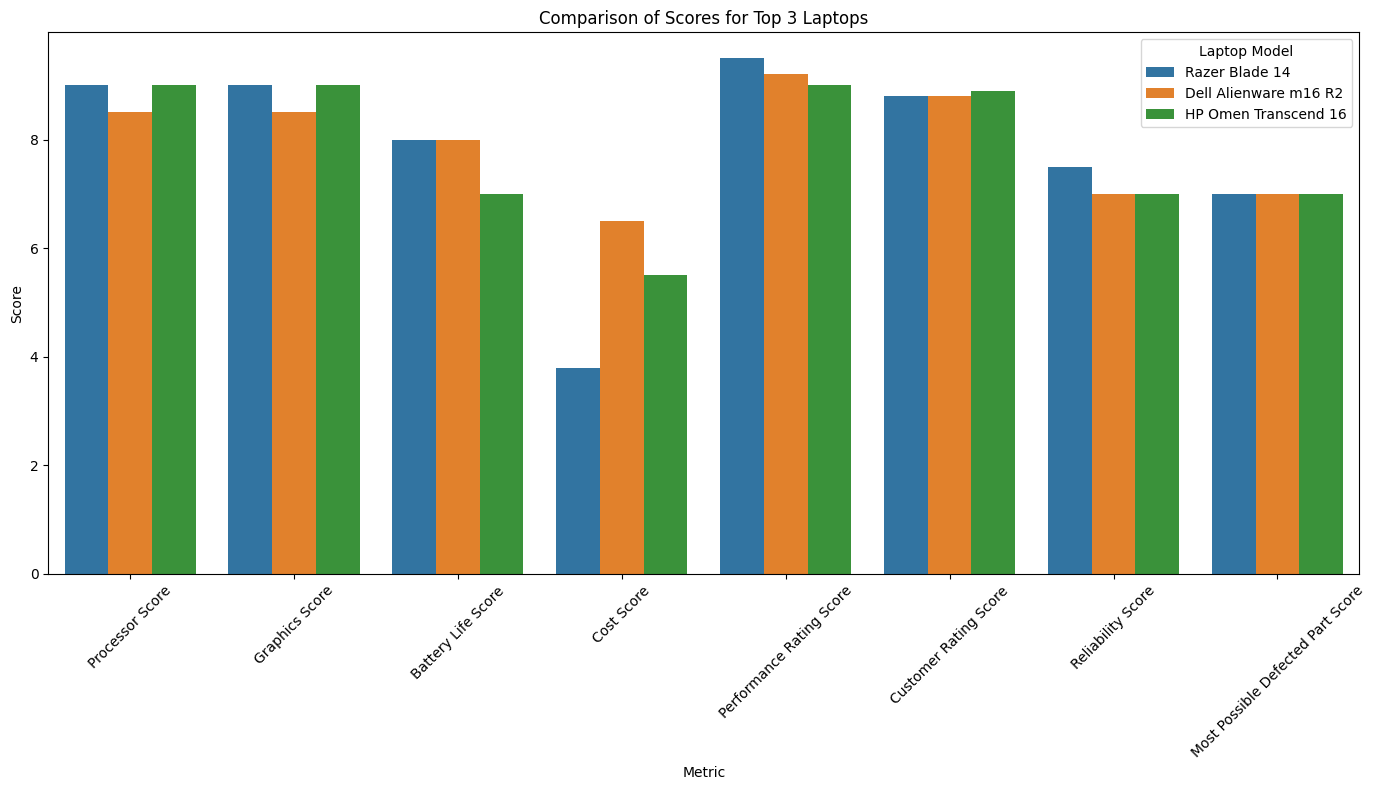

In [ ]:
# Button to update visualization
button = tk.Button(root, text="Update Visualization", command=update_visualization)
button.grid(row=11, column=0, columnspan=2)

# Run the Tkinter loop
root.mainloop()